In [16]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from skimage.morphology import skeletonize

# --- Load Image ---
path = "cutimg.jpg"
img = cv2.imread(path)
# Convert BGR to RGB for matplotlib display
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# --- Step 1: Preprocessing ---
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
blur = cv2.GaussianBlur(gray, (5, 5), 0)

# Use Otsu's method for a more "adaptive" threshold
# Your original code calculated this but didn't use it.
ret_otsu, th = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
ret, th = cv2.threshold(blur, 127, 255, cv2.THRESH_BINARY)



# Invert the threshold (Hough needs white lines on black background)
# This assumes your lines are dark on a light background.
th_inverted = cv2.bitwise_not(th)

In [20]:
# --- Step 2: Morphological Closing ---
# This helps connect small breaks in the lines

kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (7, 7))
closed = cv2.morphologyEx(th_inverted, cv2.MORPH_CLOSE, kernel)

skeleton = skeletonize(closed > 0)

#    - Convert the boolean skeleton back to a uint8 (0/255) image
#      so OpenCV functions can use it.
skeleton_img = (skeleton * 255).astype(np.uint8)


# --- Step 3: Hough Line Detection ---
# We run this on the 'closed' image
lines = cv2.HoughLinesP(skeleton_img, 1, np.pi/180, 30,
                      minLineLength=20, maxLineGap=20)

# --- Step 4: Extract Endpoints and Draw Lines ---
# Create a copy of the original color image to draw on
vis_lines = img_rgb.copy()
endpoints = []

if lines is not None:
    print(f"--- Found {len(lines)} Line Segments ---")
    for line in lines:
        x1, y1, x2, y2 = line[0]
        
        # Calculate angle in degrees
        angle = np.arctan2(y2 - y1, x2 - x1) * 180.0 / np.pi
        
        # Normalize angle to be between 0 and 180 degrees
        if angle < 0:
            angle += 180
            
        # Determine the "position key" for grouping
        # For horizontal-ish lines, this is their average 'y'
        # For vertical-ish lines, this is their average 'x'
        if abs(angle) < 45 or abs(angle) > 135: # Horizontal-ish
            # Use average y as the position key
            position_key = (y1 + y2) / 2
        else: # Vertical-ish
            # Use average x as the position key
            position_key = (x1 + x2) / 2
            
        processed_lines.append((angle, position_key, x1, y1, x2, y2))
        
    # 3. Group lines
    # Sort by angle first, then by position
    processed_lines.sort(key=lambda l: (l[0], l[1]))
    
    merged_lines = []
    if not processed_lines:
        return # No lines to process
        
    # Start the first group
    current_group = [processed_lines[0]]
    last_line = processed_lines[0]
    
    for i in range(1, len(processed_lines)):
        current_line = processed_lines[i]
        
        # Check if this line belongs to the current group
        if (abs(current_line[0] - last_line[0]) < angle_threshold and
            abs(current_line[1] - last_line[1]) < position_threshold):
            
            # Yes, add to group
            current_group.append(current_line)
        else:
            # No, finalize the previous group
            if current_group:
                # Get all points from the group
                points = []
                for l in current_group:
                    points.append((l[2], l[3]))
                    points.append((l[4], l[5]))
                
                # Fit a new line to all points in the group
                # This gives us the extreme ends of the merged line
                points = np.array(points)
                
                # For vertical-ish lines: find min/max y
                # (Angle is ~90)
                if abs(current_group[0][0] - 90) < 45: 
                    min_y = np.min(points[:, 1])
                    max_y = np.max(points[:, 1])
                    avg_x = int(np.mean(points[:, 0]))
                    merged_lines.append(((avg_x, min_y), (avg_x, max_y)))
                
                # For horizontal-ish lines: find min/max x
                # (Angle is ~0 or ~180)
                else: 
                    min_x = np.min(points[:, 0])
                    max_x = np.max(points[:, 0])
                    avg_y = int(np.mean(points[:, 1]))
                    merged_lines.append(((min_x, avg_y), (max_x, avg_y)))
                    
            # Start a new group
            current_group = [current_line]
            
        last_line = current_line

    # 4. Draw the new, merged lines
    # (Don't forget to process the very last group!)
    # ... (Add logic for the last group, similar to above) ...
    
    # Now, draw the merged lines on your 'vis' image
    for (pt1, pt2) in merged_lines:
        # Green lines for merged, to distinguish from raw (red)
        cv2.line(vis, pt1, pt2, (0, 255, 0), 2)

# --- Step 5: Visualization ---
# Show the steps of the process
fig, axs = plt.subplots(1, 4, figsize=(20, 5))

axs[0].imshow(img_rgb)
axs[0].set_title("Original")
axs[0].axis('off')

axs[1].imshow(th_inverted, cmap='gray')
axs[1].set_title("Inverted Threshold")
axs[1].axis('off')

axs[2].imshow(closed, cmap='gray')
axs[2].set_title("Morphological Closing")
axs[2].axis('off')

axs[3].imshow(vis_lines)
axs[3].set_title("Detected Hough Lines")
axs[3].axis('off')

plt.tight_layout()
plt.show()

# You can now use the 'endpoints' list for further processing
# print("\nFinal Endpoints List:")
# print(endpoints)

SyntaxError: 'return' outside function (2014315456.py, line 54)

--- Found 25 Raw Line Segments ---
--- Merged into 16 Final Lines ---


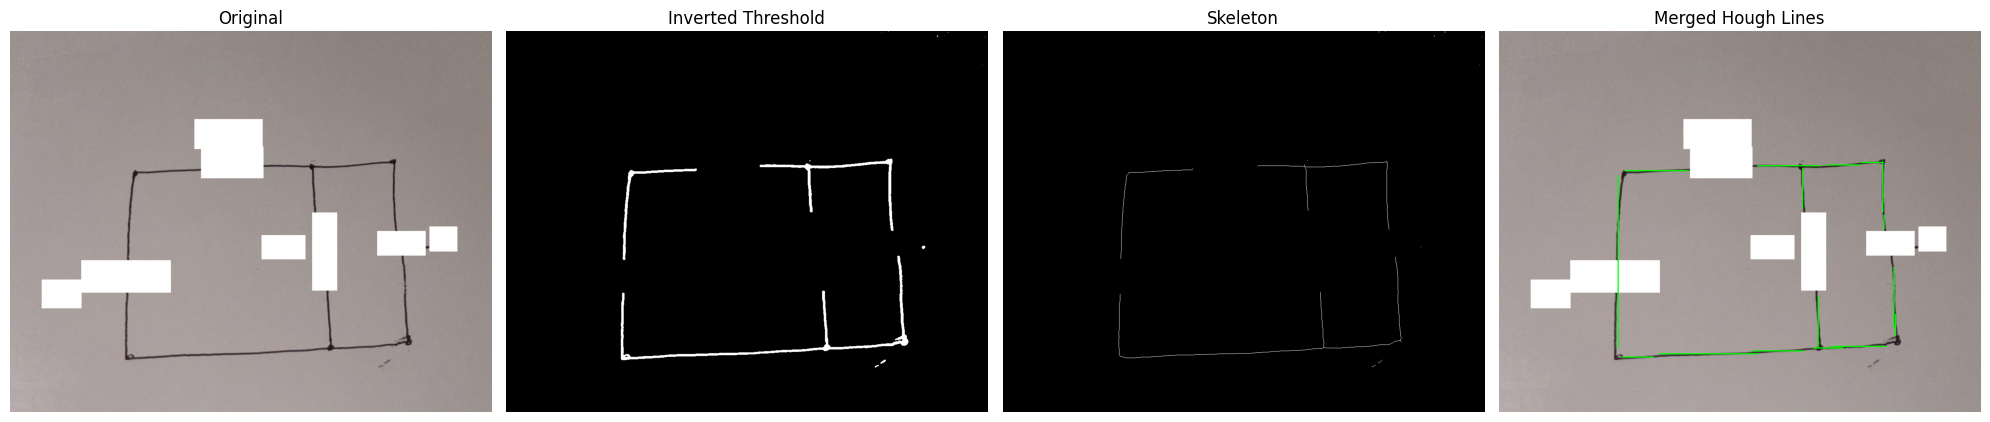


Final Endpoints List:
[((628, 327), (782, 327)), ((935, 446), (935, 481)), ((775, 643), (775, 769)), ((963, 688), (963, 741)), ((737, 333), (737, 431)), ((959, 573), (959, 719)), ((932, 316), (932, 439)), ((289, 351), (289, 770)), ((795, 325), (877, 325)), ((807, 766), (939, 766)), ((878, 319), (931, 319)), ((614, 777), (740, 777)), ((305, 339), (460, 339)), ((298, 792), (375, 792)), ((388, 784), (629, 784)), ((762, 770), (835, 770))]


In [22]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.morphology import skeletonize

# --- Assuming 'img_rgb', 'th_inverted' are loaded ---

# --- Step 2: Morphological Closing & Skeletonization ---
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (7, 7))
closed = cv2.morphologyEx(th_inverted, cv2.MORPH_CLOSE, kernel)

skeleton = skeletonize(closed > 0)
skeleton_img = (skeleton * 255).astype(np.uint8)

# --- Step 3: Hough Line Detection ---
lines = cv2.HoughLinesP(skeleton_img, 1, np.pi/180, 30,
                      minLineLength=20, maxLineGap=20)

# --- Step 4: Extract, Merge, and Draw Lines ---
# Create a copy of the original color image to draw on
vis_lines = img_rgb.copy()

# FIX: Initialize 'endpoints' (which you had) and 'processed_lines' (which was missing)
endpoints = []
processed_lines = []

if lines is not None:
    print(f"--- Found {len(lines)} Raw Line Segments ---")
    
    # FIX: Define the merging thresholds
    angle_threshold = 10.0  # How close in angle (degrees)
    position_threshold = 8  # How close in position (pixels)
    
    # 2. Process all raw lines
    for line in lines:
        x1, y1, x2, y2 = line[0]
        angle = np.arctan2(y2 - y1, x2 - x1) * 180.0 / np.pi
        
        if angle < 0:
            angle += 180
            
        if abs(angle) < 45 or abs(angle) > 135: # Horizontal-ish
            position_key = (y1 + y2) / 2
        else: # Vertical-ish
            position_key = (x1 + x2) / 2
            
        processed_lines.append((angle, position_key, x1, y1, x2, y2))
        
    # 3. Group lines
    if len(processed_lines) > 0:
        processed_lines.sort(key=lambda l: (l[0], l[1]))
    
        current_group = [processed_lines[0]]
        last_line = processed_lines[0]
        
        for i in range(1, len(processed_lines)):
            current_line = processed_lines[i]
            
            if (abs(current_line[0] - last_line[0]) < angle_threshold and
                abs(current_line[1] - last_line[1]) < position_threshold):
                
                current_group.append(current_line)
            else:
                # Finalize the previous group
                if current_group:
                    points = []
                    for l in current_group:
                        points.append((l[2], l[3]))
                        points.append((l[4], l[5]))
                    points = np.array(points)
                    
                    if abs(current_group[0][0] - 90) < 45: # Vertical-ish
                        min_y = np.min(points[:, 1])
                        max_y = np.max(points[:, 1])
                        avg_x = int(np.mean(points[:, 0]))
                        # FIX: Add to 'endpoints' list
                        endpoints.append(((avg_x, min_y), (avg_x, max_y)))
                    else: # Horizontal-ish
                        min_x = np.min(points[:, 0])
                        max_x = np.max(points[:, 0])
                        avg_y = int(np.mean(points[:, 1]))
                        # FIX: Add to 'endpoints' list
                        endpoints.append(((min_x, avg_y), (max_x, avg_y)))
                        
                current_group = [current_line]
                
            last_line = current_line

        # --- FIX: Process the VERY LAST group after the loop ends ---
        if current_group:
            points = []
            for l in current_group:
                points.append((l[2], l[3]))
                points.append((l[4], l[5]))
            points = np.array(points)
            
            if abs(current_group[0][0] - 90) < 45: # Vertical-ish
                min_y = np.min(points[:, 1])
                max_y = np.max(points[:, 1])
                avg_x = int(np.mean(points[:, 0]))
                endpoints.append(((avg_x, min_y), (avg_x, max_y)))
            else: # Horizontal-ish
                min_x = np.min(points[:, 0])
                max_x = np.max(points[:, 0])
                avg_y = int(np.mean(points[:, 1]))
                endpoints.append(((min_x, avg_y), (max_x, avg_y)))
    
    print(f"--- Merged into {len(endpoints)} Final Lines ---")

    # 4. Draw the new, merged lines
    for (pt1, pt2) in endpoints:
        # Green lines for merged
        # FIX: Draw on 'vis_lines', not 'vis'
        cv2.line(vis_lines, pt1, pt2, (0, 255, 0), 2)

# --- Step 5: Visualization ---
# (This section was already correct)
fig, axs = plt.subplots(1, 4, figsize=(20, 5))

axs[0].imshow(img_rgb)
axs[0].set_title("Original")
axs[0].axis('off')

axs[1].imshow(th_inverted, cmap='gray')
axs[1].set_title("Inverted Threshold")
axs[1].axis('off')

axs[2].imshow(skeleton_img, cmap='gray') # Show the skeleton
axs[2].set_title("Skeleton")
axs[2].axis('off')

axs[3].imshow(vis_lines)
axs[3].set_title("Merged Hough Lines")
axs[3].axis('off')

plt.tight_layout()
plt.show()

# You can now use the 'endpoints' list for further processing
print("\nFinal Endpoints List:")
print(endpoints)